In [1]:
#from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from scipy import ndimage
from scipy import interpolate
import pandas as pd 
import numpy.matlib
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(threshold='nan')
from matplotlib.colors import from_levels_and_colors
import matplotlib.colors as mcolors
import glob
import os
import wradlib as wrl
from numpy.lib.stride_tricks import as_strided as strided
import matplotlib
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
def beam_height_n(r, theta, re=6374000., ke=4./3.):
    return np.sqrt( r**2 + (ke*re)**2 + 2*r*ke*re*np.sin(np.radians(theta)) ) - ke*re
def cmap_discretize(cmap, N):
    """Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)
    """

    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0.,0.,0.,0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N+1)
    cdict = {}
    for ki,key in enumerate(('red','green','blue')):
        cdict[key] = [ (indices[i], colors_rgba[i-1,ki], colors_rgba[i,ki])
                       for i in xrange(N+1) ]
    # Return colormap object.
    return mcolors.LinearSegmentedColormap(cmap.name + "_%d"%N, cdict, 1024)
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)f
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]
class FixPointNormalize(matplotlib.colors.Normalize):
    """ 
    Inspired by https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib
    Subclassing Normalize to obtain a colormap with a fixpoint 
    somewhere in the middle of the colormap.

    This may be useful for a `terrain` map, to set the "sea level" 
    to a color in the blue/turquise range. 
    """
    def __init__(self, vmin=None, vmax=None, sealevel=0, col_val = 0.21875, clip=False):
        # sealevel is the fix point of the colormap (in data units)
        self.sealevel = sealevel
        # col_val is the color value in the range [0,1] that should represent the sealevel.
        self.col_val = col_val
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.sealevel, self.vmax], [0, self.col_val, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def mask_knans(a, x):
    #Interpolates, then masks interpolated values if over a certain threshold.
    a = np.asarray(a)
    k = a.size
    n = np.append(np.isnan(a), [False] * (x - 1))
    m = np.empty(k, np.bool8)
    m.fill(True)

    s = n.strides[0]
    i = np.where(strided(n, (k + 1 - x, x), (s, s)).all(1))[0][:, None]
    i = i + np.arange(x)
    i = pd.unique(i[i < k])

    m[i] = False

    return m




In [7]:
#file_name='/Users/brandonh/Documents/Data/Boxpol_QVP/qvp_2016-03-31.npy'
file_name='/Volumes/RadarDrive/Boxpol_QVP/qvp_2016-03-31.npy'
fname='HC_'+file_name[35:-4]
qvp_data=np.load(file_name)
zdr_offset=.75
zh_offset=3.5
zh=qvp_data[:,:,0]#+zh_offset
zdr=qvp_data[:,:,1]#"+zdr_offset
rhohv=qvp_data[:,:,2]
kdp=qvp_data[:,:,3]
cdr=qvp_data[:,:,5]
rhoc=qvp_data[:,:,6]
zh[(rhoc>1)|(rhoc<.8)]=np.nan
zdr[(rhoc>1)|(rhoc<.8)]=np.nan
rhohv[(rhoc>1)|(rhoc<.8)]=np.nan
kdp[(rhoc>1)|(rhoc<.8)]=np.nan

z=qvp_data[:,:,0]
bins=qvp_data[:,:,0]
bins=bins.shape[0]
tradar=np.linspace(0,24,z.shape[1])
radar_height=99.5
radar_range=np.linspace(0, 100000,bins)
theta=8.2
beam_height =( beam_height_n(radar_range, theta) + radar_height)/ 1000 



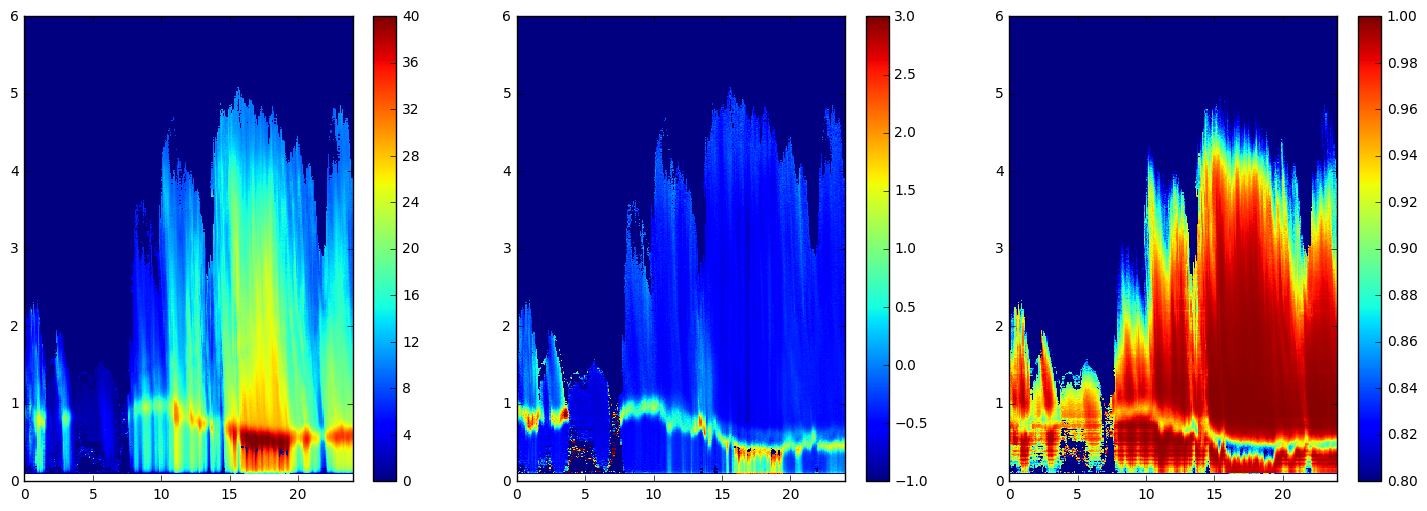

'plt.subplot(1,4,4)\nplt.pcolormesh(tradar,beam_height,kdp,vmin=-1,vmax=1)\nplt.xlim(0,24)\nplt.ylim(0,3)\nplt.colorbar()\nplt.show()'

In [8]:
zht=np.copy(qvp_data[:,:,0])
zdrt=np.copy(qvp_data[:,:,1])
rhohvt=np.copy(qvp_data[:,:,2])
rhoct=np.copy(qvp_data[:,:,2])


'''kdp[(zht<5)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=np.nan
zdr[(zht<5)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=np.nan
rhohv[(zht<5)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=np.nan
zh[(zht<5)|(rhoct>1)|(rhoct<.8)|(zdrt<-1)]=np.nan
#zh[(z<5)|(rhoc>1)]=np.nan'''

colors1 = plt.cm.binary_r(np.linspace(0, .5, 32))
colors2 = plt.cm.jet(np.linspace(0, 1, 96))
colors = np.vstack((colors1, colors2))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

fig, ax = plt.subplots(nrows = 1, ncols=4, figsize=(18,6) )
plt.subplot(1,3,1)
plt.pcolormesh(tradar,beam_height,zh,vmin=0,vmax=40,)
plt.xlim(0,24)
plt.ylim(0,6)
plt.colorbar()

plt.subplot(1,3,2)
plt.pcolormesh(tradar,beam_height,zdr,vmin=-1,vmax=3)
plt.xlim(0,24)
plt.ylim(0,6)
plt.colorbar()

plt.subplot(1,3,3)
plt.pcolormesh(tradar,beam_height,rhohv,vmin=.8,vmax=1)
plt.xlim(0,24)
plt.ylim(0,6)
plt.colorbar()
plt.show()

'''plt.subplot(1,4,4)
plt.pcolormesh(tradar,beam_height,kdp,vmin=-1,vmax=1)
plt.xlim(0,24)
plt.ylim(0,3)
plt.colorbar()
plt.show()'''

In [9]:
######## MELTING LAYER DETECTION ########

#qvp_zh=qvp_data[:,:,0]#+zh_offset
qvp_zh=np.copy(zh)
z0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1])) 
rho0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
zdr0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
kdp0=np.zeros((qvp_zh.shape[0],qvp_zh.shape[1]))
hmask=np.where((beam_height>1.5))#|(beam_height<1))
##################
for ii in range(z0.shape[1]):
    #normalize Z
    z=np.copy(zh[:,ii])
    zmask= np.where((z < 0) | (z>60))
    z[zmask]=np.nan
    z0[:,ii]=(z-np.nanmin(z))/(np.nanmax(z)-np.nanmin(z))

    #normalize rho
    rho=np.copy(rhohv[:,ii])
    rhomask= np.where((rho <0.8) | (rho>.97)) 
    rho[rhomask]=np.nan
    rho[hmask]=np.nan
    rho0[:,ii]=(rho-np.nanmin(rho))/(np.nanmax(rho)-np.nanmin(rho))

    #normalize ZDR
    zd=np.copy(zdr[:,ii])
    zdmask= np.where((zd < .2)|(zd > 4))
    zd[zdmask]=np.nan
    zd[hmask]=np.nan
    zdr0[:,ii]=(zd-np.nanmin(zd))/(np.nanmax(zd)-np.nanmin(zd))

#z=qvp_data[:,:,0]#+zh_offset
#zdr0[(z<5)|(rhoc>1)|(rhoc<.8)]=np.nan
#rho0[z<5]=np.nan
#zdr
#################
i=zdr0*(1-rho0)
dz=ndimage.sobel(i,0)
#################
top=np.zeros(dz.shape[1])
bot=np.zeros(dz.shape[1])
for ii in range(dz.shape[1]):
    d=pd.rolling_median(dz[:,ii],4,min_periods=1)
    if np.nansum(np.abs(d))>0:
        t=np.nanargmin(d,0)
        b=np.nanargmax(d,0)
        top[ii]=beam_height[t]
        bot[ii]=beam_height[b]
    else:
        top[ii]=np.nan
        bot[ii]=np.nan
    if bot[ii]>top[ii]:
        bot[ii]=np.nan
        
tt=np.copy(top)
bt=np.copy(bot)
##################
r=3
a=top
x=[]
m=np.zeros(len(a))
above=np.empty(len(a))
tout=np.empty(len(a))
for ii in range(len(a)):
    if ~np.isnan(a[ii]):
        x.append(a[ii])
        x2=np.asarray(x)
        if ii<=1:
            m[ii]=x2[ii]
            #print ii, m[ii]
        elif (ii>1)&(ii<r):
            m[ii]=np.nanmedian(x2[len(x2)-len(x2):len(x2)-1])
        else:
            m[ii]=np.nanmedian(x2[len(x2)-r:len(x2)-1])
            
    elif np.isnan(a[ii]):
        m[ii]=np.nan
    
    above[ii]=np.abs(a[ii]-m[ii])
    if above[ii]>1:
        x=x[:-1]
        #x[len(x2)-1]=np.nan
        #print len(x2),x[:len(x2)]
        tout[ii]=np.nan
    else:
        tout[ii]=m[ii]    
  

b=bot
x=[]
m=np.zeros(len(a))
below=np.empty(len(a))
bout=np.empty(len(a))
for ii in range(len(a)):
    if ~np.isnan(b[ii]):
        x.append(b[ii])
        x2=np.asarray(x)
        if ii<=1:
            m[ii]=x2[ii]
            #print ii, m[ii]
        elif (ii>1)&(ii<r):
            m[ii]=np.nanmedian(x2[len(x2)-len(x2):len(x2)-1])
        else:
            m[ii]=np.nanmedian(x2[len(x2)-r:len(x2)-1])
            
    elif np.isnan(b[ii]):
        m[ii]=np.nan
    
    below[ii]=np.abs(b[ii]-m[ii])
    if below[ii]>1:
        x=x[:-1]
        #x[len(x2)-1]=np.nan
        #print len(x2),x[:len(x2)]
        bout[ii]=np.nan
    else:
        bout[ii]=m[ii] 

        
top[(np.isnan(tout))|(np.isnan(bout))]=np.nan
bot[(np.isnan(bout))|(np.isnan(tout))]=np.nan


##################   
#qvp_data=np.load(file_name)
#rho=qvp_data[:,:,2]
rho=np.copy(rhohv)
#hmask=np.where(beam_height>2)
topnew=np.empty(len(top))
botnew=np.empty(len(top))
for ii in range(rho.shape[1]):
    #print ii
    r=np.copy(rho[:,ii])
    r[hmask]=np.nan

    tm=np.where(beam_height<top[ii])
    bm=np.where(beam_height>bot[ii])
    r2=np.copy(r)
    r3=np.copy(r)
    r2[tm]=np.nan
    r3[bm]=np.nan
    if np.nansum(np.abs(r2))>0:
        if ~np.isnan(top[ii]):
            if np.nanmax(r2)>=.97:
                t97=np.where(r2>=.97)
                indtop=t97[0]
                topnew[ii]=beam_height[indtop[0]]
            else:
                t97=np.nanargmax(r2)
                topnew[ii]=beam_height[t97]
        else:
            topnew[ii]=np.nan
    if ~np.isnan(bot[ii]):   
        if np.nanmax(r3)>=.97:
            b97=np.where(r3>=.97)    
            indbot=b97[0]
            botnew[ii]=beam_height[indbot[-1]]
        else:
            b97=np.nanargmax(r3)
            botnew[ii]=beam_height[b97]
    else:
        botnew[ii]=np.nan
#indtop=t97[0]
    #indbot=b97[0]
    #topnew[ii]=beam_height[indtop[0]]
    #botnew[ii]=beam_height[indbot[-1]]
mlt=np.copy(topnew)
mlb=np.copy(botnew)


####INTERPOLATION####
##TOP
y= np.copy(mlt)
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
x2=np.arange(zh.shape[1])
ynan=np.where(~np.isnan(mlt))
y[0:ynan[0][0]]=np.nan
y[ynan[0][-1]+1:]=np.nan
mltnew=np.copy(y)

##BOT
y= np.copy(mlb)
nans, x= nan_helper(y)
y[nans]= np.interp(x(nans), x(~nans), y[~nans])
x2=np.arange(zh.shape[1])
ynan=np.where(~np.isnan(mlb))
y[0:ynan[0][0]]=np.nan
y[ynan[0][-1]+1:]=np.nan
mlbnew=np.copy(y)

#a = np.array([1, np.nan, np.nan, np.nan, 3, np.nan, 4, 5, np.nan, np.nan, 6, 7])
am=mask_knans(mlt, 8)
mltnew[am==False]=np.nan
am=mask_knans(mlb, 8)
mlbnew[am==False]=np.nan


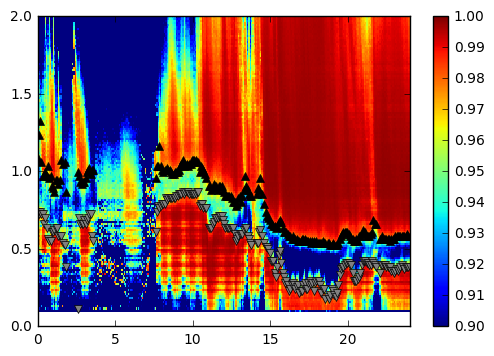

In [10]:
plt.pcolormesh(tradar,beam_height,rho,vmin=0.9,vmax=1)
plt.plot(tradar,mlt,'k^')
plt.plot(tradar,mlb,'v',color=[.5,.5,.5])
plt.xlim(0,24)
plt.ylim(0,2)
plt.colorbar()
plt.show()